# Modelo SIR con los datos del COVID CHILE
Note que la EDO es:
$$
\begin{matrix}
&\frac{d S}{d t}(t)=-\beta S(t) I(t)&, \quad S(0)=S_{0}\\
&\frac{d I}{d t}(t)=\beta S(t) I(t)-\nu I(t)&, \quad I(0)=I_{0}\\
&\frac{d R}{d t}(t)=\nu I(t)&, \quad R(0)=R_{0}
\end{matrix}
$$
Donde:
* S(t) es el número de personas sanas al tiempo $t$
* I(t) es el número de infectados al tiempo $t$
* R(t) es el número de recuperados al tiempo $t$

Primero veamos una solución númerica. Para ello utilizaremos el siguiente preambulo.

In [1]:
rm(list = ls()); graphics.off(); cat("\014")
library(splines)
library(Matrix)
library(spam)
library(deSolve)

#------------------------------------- source files ---------------------------------------------------#

source("basis_array.R")
source("functions_to_optimize.R")
source("penalty_function.R")

Loading required package: dotCall64

Loading required package: grid

Spam version 2.5-1 (2019-12-12) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following object is masked from ‘package:Matrix’:

    det


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve




Planteamos la solución númerica con parámetros escogidos previamente (no basado en los datos)

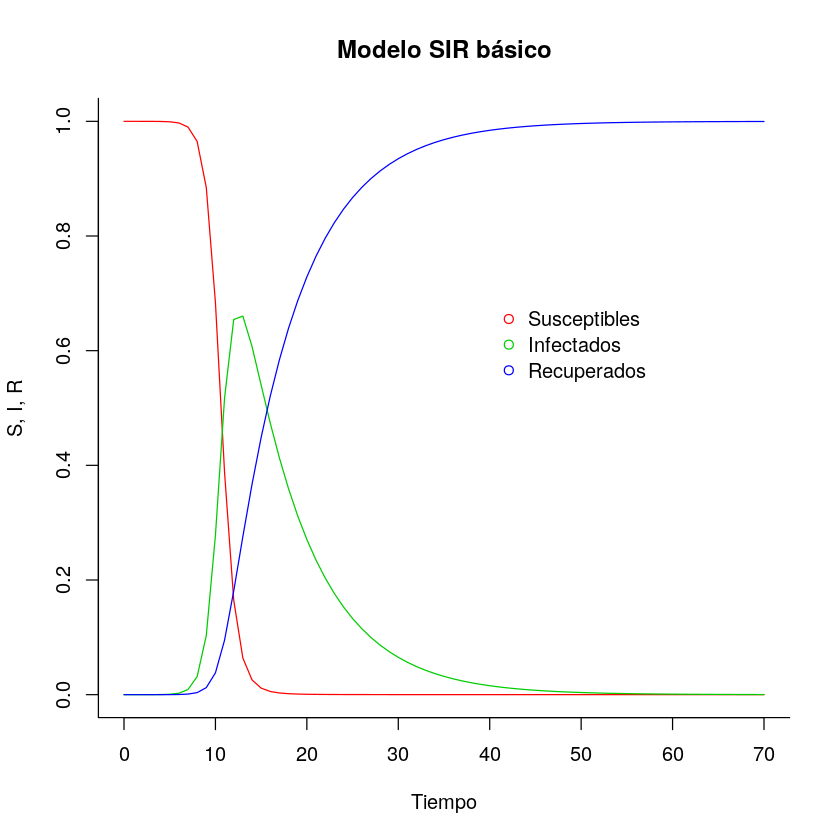

In [2]:
N=1
pars=c(beta = 1.4247,gamma = 0.14286 )
SIR = function(Time, State, Pars)
{
  with(as.list(c(State, Pars, t)),
       {
         dSanos = -Pars[1]*Sanos*Infectados 
         dInfectados = Pars[1] * Sanos * Infectados - Pars[2]*Infectados
         dRecuperados = Pars[2] *Infectados
         return(list(c(dSanos, dInfectados,dRecuperados)))
       })
}

times <- seq(0, 70, by = 1)

ini <- c(Sanos = 1-1e-6,
          Infectados = 1e-6,
          Recuperados = 0)

out = ode(ini, times, SIR, pars)

out <- as.data.frame(out*N) #aqui puede multiplicar 'out' por N
#eliminar la variable 'time' en out
out$time <- NULL

#gráfica
matplot(x = times, y = out, type = "l",
        xlab = "Tiempo", ylab = "S, I, R", main = "Modelo SIR básico",
        lwd = 1, lty = 1, bty = "l", col = 2:4)
#añadir leyenda de líneas
legend(40, 0.7, c("Susceptibles", "Infectados", "Recuperados"), 
       pch = 1, col = 2:4, bty = "n", cex = 1)

Ahora procederemos a estimar los parametros mediante lo aprendido en el PAPER.

In [3]:
dat = read.delim("covid.txt", header = F)

N = 18751405
t_obs = seq(0, len = nrow(dat))
n = length(t_obs)

y_obs_1 = N-dat[, 3] # y_obs_1 Sanos
y_obs_2 = dat[, 3]   # y_obs_2 Infectados
y_obs_3 = dat[,5]    # y_obs_3 Recuperados
y_obs = c(y_obs_1, y_obs_2 ,y_obs_3
         )

N_obs = length(y_obs) #BUSCAR QUE HACE ESTO EN EL CODIGO

min_t = min(t_obs)
max_t = max(t_obs)

In [4]:

#------------------------------------- Basis matrices -------------------------------------------------#

length_t = 1e3 
seq_t = seq(min_t, max_t, length = length_t)
ndt = 200

B_seq_t = basis_array(x = seq_t, xl = min_t, xr = max_t, ndx = ndt, deg = 3, max_derivs = 2, sparse = TRUE)
for (j in 1:length(B_seq_t))
{
B_seq_t[[j]] = as.spam(as.matrix(B_seq_t[[j]]))
}

In [5]:
#------------------------------------- stoping rules --------------------------------------------------#

tol_gamma = 1e-4
tol_ck = 1e-4
tol_theta_tau = 1e-4


In [6]:
#-------------------------------- design matrix and diff pen ------------------------------------------#

B = basis_array(x = t_obs, xl = min_t, xr = max_t, ndx = ndt, deg = 3, max_derivs = 1, sparse = TRUE)
B_0 = as.spam(as.matrix(B[[1]]))
t_B_0 = t(B_0)

tB_B = t_B_0 %*% B_0

tB_y = t_B_0 %*% cbind(y_obs_1, y_obs_2,y_obs_3)

M = dim(tB_B)[2]

D = diff(diag(M), diff = 2)
tD_D = t(D) %*% D


In [7]:
#------------------ Initial smoothing raw data and initial parameters ---------------------------------#

# smoothing for x1 and x2

las = seq(-1, 8, by = .5) # QUE HACE ESTO???
cv = ed = las * 0
i = 1

In [8]:
for(la in las)
{
  lam = 10 ^ la
  solve_A = solve(tB_B +  lam * tD_D)
  cy = solve_A %*% tB_y
  ed[i] = sum(diag(B_0 %*% solve_A %*% t_B_0))
  rss = sum((y_obs - B_0 %*% cy) ^ 2)
  cv[i] = rss/((N_obs - ed[i]) ^ 2)
  i = i + 1
}

In [9]:
lam_opt = 10 ^ las[which.min(cv)]
ck = c(solve(tB_B +  lam_opt * tD_D, tB_y))
tau_in = (N_obs - ed[which.min(cv)])/sum((y_obs - B_0 %*% matrix(ck, ncol = 3 #Generalizar
                                                                ))^2)

In [10]:
pars=c(beta = 1.4247,gamma = 0.14286, tau_0 = 0.01) # initial parameters as in section 5.2
i = 1
ck = cbind(ck, NULL)

# Aqui me esta dando error 

In [11]:
theta_tau = c(pars)
crit_gamma = crit_ck = crit_theta_tau = 1
gamma = 1e4

In [12]:
while(((crit_ck > tol_ck) | (crit_gamma > tol_gamma) | (crit_theta_tau > tol_theta_tau)) && (i < 10))
{
  theta_tau_old = theta_tau
  zandpen = c_hat_function(theta = theta_tau[-length(theta_tau)],
                           tau = theta_tau[length(theta_tau)],
                           gamma,
                           ck = ck[, i],
                           length_t,
                           seq_t,
                           B_seq_t,
                           regul = 0.0)

  z = zandpen[[1]]
  pen = zandpen[[2]]
  t_z = t(z)

  y_star = B_0 %*% matrix(z, ncol = 3 # Generalizar
                         )
  PEN = (t_z %*% pen $ R %*% z + 2 * t_z %*% pen $ r + pen $ l) 
 
  A = as.matrix(gamma * pen $ R +
                rbind(cbind(tB_B  * theta_tau[length(theta_tau)], tB_B * 0),
                cbind(tB_B * 0, tB_B * theta_tau[length(theta_tau)])))
  solve_A = solve(A, tol = 1e-50)

  ed_1 = sum(diag(B_0 %*% solve_A[1:M, 1:M] %*% (theta_tau[length(theta_tau)] * t_B_0)))
  ed_2 = sum(diag(B_0 %*% solve_A[M + 1:M, M + 1:M] %*% (theta_tau[length(theta_tau)] * t_B_0)))

  theta_tau[length(theta_tau)] = (N_obs - (ed_1 + ed_2)) / sum((y_obs - c(y_star)) ^ 2)

  den = c(PEN / (ed_1 + ed_2))

  gamma_new = 1 / (den + 1e-15)

  crit_gamma = abs((gamma - gamma_new) / gamma)
  gamma = gamma_new

  ck = cbind(ck, z)
  crit_ck = max(abs((ck[, i] - z) / ck[, i]))

  optim_parm = optim(par = theta_tau[-length(theta_tau)],
                     fn = H_fun,
                     tau =  theta_tau[length(theta_tau)],
                     gamma = gamma,
                     ck = z,
                     length_t = length_t,
                     seq_t = seq_t,
                     B_seq_t = B_seq_t,
                     regul = 0.0,
                     method = "BFGS",
                     control = list(fnscale = -1, trace = FALSE),
                     hessian = TRUE)

  theta_tau[-length(theta_tau)] = optim_parm $ par
  FIM = solve(-optim_parm $ hessian)

  crit_theta_tau = max(abs((theta_tau - theta_tau_old) / theta_tau_old))

  cat('iteration:', i,'\n')
  cat('\t', 'crit_gamma:', round(crit_gamma, 8), '\n')
  cat('\t', 'crit_ck:', round(crit_ck, 8), '\n')
  cat('\t', 'crit_theta_tau:', round(crit_theta_tau, 8), '\n')
  cat('\t', 'gamma:', round(gamma, 8), '\n')
  cat('\t', 'tau:', round(tail(theta_tau, n = 1), 8), '\n')
  cat('\t', 'theta:', head(theta_tau, n = -1), '\n')
  
  i = i+1
}

ERROR: Error in z(t(h1) %*% h1): could not find function "z"


In [ ]:
 theta_tau_old = theta_tau
  zandpen = c_hat_function(theta = theta_tau[-length(theta_tau)],
                           tau = theta_tau[length(theta_tau)],
                           gamma,
                           ck = ck[, i],
                           length_t,
                           seq_t,
                           B_seq_t,
                           regul = 0.0)

  z = zandpen[[1]]
  pen = zandpen[[2]]
  t_z = t(z)

  y_star = B_0 %*% matrix(z, ncol = 3 # Generalizar
                          )

In [ ]:
zandpen = c_hat_function(theta = theta_tau[-length(theta_tau)],
                           tau = theta_tau[length(theta_tau)],
                           gamma,
                           ck = ck[, i],
                           length_t,
                           seq_t,
                           B_seq_t,
                           regul = 0.0)     